# New Tables: Industry level

* Faire les tableaux suivants:
  * Tableau 4: Kuznet: benchmark → Revision
      * Trouver un tableau avec les déciles pour montrer:
        * turning point croissant pour des villes avec une dominance étatique de plus en plus large
      * Regarder si gdp/cap prix constant
      * Indiquer les turning points dans les tableaux
* Partie 6:
  * Tableau 8: 
    * estimer 2 modèles sur des échantillons differents
      * modèle 1 →  TCZ * Polluted * Period
      * modèle 2 → Target * polluted*Period  
    * Echantillonnage → prendre soit industry soit city industry
      * Big
        * Via Herfhindal 
          * benchmark →Revision
      * Foreign 
        * via output/capital/employment 
      * SOEs
        * via output/capital/employment 
      * SPZ
      * Coastal
    * Chaque tableau avec Panel A pour supérieur threshold, Panel B pour inférieur threshold
  * Tableau 9:
    * Enlever SPZ & Coastal
    * estimer 2 modèles sur des échantillons differents
      * modèle 1 →  TCZ * Polluted * Period
      * modèle 2 → Target * polluted*Period  
    * Idem tableau 8

In [1]:
import pandas as pd
from Fast_connectCloud import connector
import numpy as np

In [2]:
import functions.latex_beautify as lb

%load_ext autoreload
%autoreload 2

In [3]:
gs = connector.open_connection(online_connection = False,
                              path_credential = '/Users/thomas/Google Drive/Projects/Client_Oauth/Google_auth')

service = gs.connect_remote('GCP')

Service account storage and Bigquery are now connected. 
Service account storage is stored as <google.cloud.storage.client.Client object at 0xa2284c210> and accessible with "Storage_account" 
Service account Bigquery is stored as <google.cloud.bigquery.client.Client object at 0xa1fe02290> and accessible with "bigquery_account"


In [4]:
%put df_final --to R

from GoogleDrivePy.google_platform import connect_cloud_platform
project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project, 
                                             service_account = service['GoogleCloudP'])    
query = (
          "SELECT * "
            "FROM China.SBC_pollution_China "

        )

df_final = gcp.upload_data_from_bigquery(query = query, location = 'US')
df_final.head()

,year,Period,Province_en,Lower_location,Larger_location,Coastal,cityen,geocode4_corr,TCZ_c,target_c,effort_c,industry,ind2,Short,output_fcit,capital_fcit,labour_fcit,out_share_SOE,cap_share_SOE,lab_share_SOE,tso2_cit,tso2_i,tCOD_cit,twaste_water_cit,polluted_di,polluted_mi,polluted_thre,FE_c_i,FE_t_i,FE_t_c
0,2002,Before,Shanxi,Central,Central,False,Yuncheng,1408,TCZ,0.485030,Above,3329,33,Smelting Non-ferrous Metals,0.000687,0.000293,0.00036,0.027567,0.221018,0.113467,24500,168934.454545,0.0,500,Above,Below,Above,11104,1573,889
1,2006,After,Hunan,Central,Central,False,Xiangtan,4303,TCZ,0.092754,Below,3329,33,Smelting Non-ferrous Metals,0.000950,0.000148,0.00023,0.027567,0.221018,0.113467,2304,168934.454545,0.0,300,Above,Below,Above,11105,1574,420
2,2007,After,Hunan,Central,Central,False,Xiangtan,4303,TCZ,0.092754,Below,3329,33,Smelting Non-ferrous Metals,0.001715,0.000365,0.00023,0.027567,0.221018,0.113467,2304,168934.454545,0.0,240,Above,Below,Above,11105,1572,421
3,2007,After,Liaoning,Northeast,Eastern,True,Jinzhou,2107,TCZ,0.080512,Below,3329,33,Smelting Non-ferrous Metals,0.007730,0.001296,0.00089,0.027567,0.221018,0.113467,3200,168934.454545,0.0,0,Above,Below,Above,11103,1572,287
4,2002,Before,Liaoning,Northeast,Eastern,True,Shenyang,2101,TCZ,0.230076,Above,3329,33,Smelting Non-ferrous Metals,0.000997,0.000052,0.00135,0.027567,0.221018,0.113467,3840,168934.454545,0.0,3500,Above,Below,Above,11106,1573,432


/Users/thomas/anaconda3/lib/python3.7/site-packages/pyarrow/feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


In [5]:
options(warn=-1)
library(tidyverse)
library(lfe)
library(lazyeval)
library('progress')

path = "functions/SBC_pollution_R.R"
source(path)
path = "functions/SBC_pollutiuon_golatex.R"
source(path)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lazyeval’


The following objects are masked from ‘package:purrr’:

    is_atomic, is_formula



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




In [6]:
df_final <- df_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )
head(df_final)

,year,Period,Province_en,Lower_location,Larger_location,Coastal,cityen,geocode4_corr,TCZ_c,target_c,⋯,tso2_cit,tso2_i,tCOD_cit,twaste_water_cit,polluted_di,polluted_mi,polluted_thre,FE_c_i,FE_t_i,FE_t_c
,<dbl>,<fct>,<fct>,<fct>,<fct>,<lgl>,<fct>,<dbl>,<fct>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,2002,Before,Shanxi,Central,Central,FALSE,Yuncheng,1408,TCZ,0.48502998,⋯,24500,168934.5,0,500,Above,Below,Above,11104,1573,889
2,2006,After,Hunan,Central,Central,FALSE,Xiangtan,4303,TCZ,0.09275420,⋯,2304,168934.5,0,300,Above,Below,Above,11105,1574,420
3,2007,After,Hunan,Central,Central,FALSE,Xiangtan,4303,TCZ,0.09275420,⋯,2304,168934.5,0,240,Above,Below,Above,11105,1572,421
4,2007,After,Liaoning,Northeast,Eastern,TRUE,Jinzhou,2107,TCZ,0.08051164,⋯,3200,168934.5,0,0,Above,Below,Above,11103,1572,287
5,2002,Before,Liaoning,Northeast,Eastern,TRUE,Shenyang,2101,TCZ,0.23007570,⋯,3840,168934.5,0,3500,Above,Below,Above,11106,1573,432
6,2002,Before,Guangdong,Coastal,Eastern,TRUE,Meizhou,4414,No_TCZ,0.02596999,⋯,72752,168934.5,15500,115000,Above,Below,Above,11107,1573,909


# Partie 6

## Tableau 8 A and B 

Estimate the following models using different subsamples:

### Model A 

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { TCZ }_{i} \times \text { Polluting sectors }_{k} \right)+\nu_{i k}+\lambda_{i t}+\phi_{k t}+\epsilon_{i k t}
$$

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { TCZ }_{i} \times \text { Polluting sectors }_{k} \times \text{ Share X}_i \right)+\nu_{i k}+\lambda_{i t}+\phi_{k t}+\epsilon_{i k t}
$$

### Model B

$$
Log SO2 emission _{i k t}=\alpha\left(\text { Period } \times \text { Target }_{i} \times \text { Polluting sectors }_{k}\right)+\nu_{i k}+\lambda_{i t}+\phi_{k t}+\epsilon_{i k t}
$$

* Size
    * Via Herfhindal 
        * benchmark →Revision
* Foreign 
    * via output/capital/employment 
* SOEs
    * via output/capital/employment 
* SPZ
* Coastal

## Load Data

### Compute Herfhindal: proxy Size

$$
H=\sum_{i=1}^{N} s_{i}^{2}
$$

where $s_i$ is the market share of city $i$ in the industry, and $N$ is the number of firms. 

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by city-industry: `market_share_cit`
- Step 2: compute the sum of squared market share by industry: `Herfindahl_it`
- Step 3: Compute the average across time: `Herfindahl_i`
- Step 4: Compute the deciles of step 3: `decile_herfhindal_i`
    - Low decile implies a low concentration within sectors
    - High decile implies a high concentration within sectors

In [7]:
query = """
WITH sum_cit AS (
  SELECT geocode4_corr, cic, sum(output) as sum_o_cit, year
  FROM China.asif_firm_china 
  WHERE year >= 2002 AND year <= 2007
  AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY geocode4_corr, cic, year
) 
SELECT * 
FROM 
  (WITH sum_it AS (
    SELECT cic, SUM(sum_o_cit) as sum_o_it, year
    FROM sum_cit
    WHERE year >= 2002 AND year <= 2007
    GROUP BY year, cic
)
SELECT *
FROM
  (WITH ms_cit AS (
    SELECT  sum_cit.cic, sum_cit.geocode4_corr, sum_cit.year,
    sum_cit.sum_o_cit/NULLIF(sum_it.sum_o_it, 0) as market_share_cit
    FROM sum_cit
    LEFT JOIN sum_it
ON (
sum_cit.year = sum_it.year AND 
sum_cit.cic = sum_it.cic
)
)
SELECT *
FROM
  (WITH agg_1 AS (
SELECT cic, SUM(POW(market_share_cit, 2)) as Herfindahl_it,
year
FROM ms_cit
GROUP BY year, cic
ORDER BY year, cic 
)
SELECT *
FROM (
WITH avg_H_i AS (
SELECT cic, AVG(Herfindahl_it) as Herfindahl_i
FROM agg_1
GROUP BY cic
)
SELECT cic as industry, Herfindahl_i ,
NTILE(10)  OVER (ORDER BY Herfindahl_i) as
decile_herfhindal_i
FROM avg_H_i
ORDER BY decile_herfhindal_i
))))
"""
df_herfhindal = gcp.upload_data_from_bigquery(query = query,
                                         location = 'US')
df_herfhindal['decile_herfhindal_i'].value_counts().sort_index()

1     74
2     74
3     74
4     74
5     73
6     73
7     73
8     73
9     73
10    73
Name: decile_herfhindal_i, dtype: int64

### Compute Ownership: proxy Foreign/SOE

$$\sum output_{io}/ \sum output_i$$

- with $i$ stands for industry
- $o$ stands for ownership (Foreign vs Domestic or SOE vs private)



#### Foreign vs domestic

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by industry, ownership (Foreign/Domestic): `Share_X_io`
- Step 2: Compute dummy when share Foreign above share domestic by industry


In [8]:
query_share_foreign = """ 
WITH sum_io AS (
  SELECT 
    case WHEN ownership = 'Foreign' THEN 'FOREIGN' ELSE 'DOMESTIC' END AS OWNERSHIP, 
    SUM(output / 10000000) as output_io, 
    SUM(fa_net / 10000000) as fa_net_io, 
    SUM(employment / 100000) as employment_io,
    cic
  FROM 
    China.asif_firm_china 
  WHERE 
    year >= 2002 
    AND year <= 2007 
    AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY 
    OWNERSHIP, 
    cic
) 
SELECT 
  * 
FROM 
  (
    WITH sum_i AS(
      SELECT 
        SUM(output_io) as output_i, 
        SUM(fa_net_io) as fa_net_i, 
        SUM(employment_io) as employment_i, 
        cic AS cic_b
      FROM 
        sum_io 
      GROUP BY 
        cic
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH share_io AS(
          SELECT 
            OWNERSHIP, 
            output_io / output_i AS share_output_io, 
            fa_net_io / fa_net_i AS share_fa_net_io, 
            employment_io / employment_i AS share_employement_io, 
            cic
          FROM 
            sum_io 
            LEFT JOIN sum_i ON sum_io.cic = sum_i.cic_b 
        ) 
        SELECT 
        * 
        FROM(
        WITH decile_i AS (
        SELECT 
        cic as industry,
        OWNERSHIP,  
        NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_output_io) 
          as rank_share_output_i,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_fa_net_io) 
          as rank_share_capital_i,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_employement_io) 
          as rank_share_employement_i,
          share_output_io,
          share_fa_net_io,
          share_employement_io
        FROM share_io
        )
        SELECT * 
        FROM decile_i 
        /*WHERE OWNERSHIP = 'FOREIGN'*/
        )
        )
        )
"""
df_share_foreign = gcp.upload_data_from_bigquery(query = query_share_foreign,
                                         location = 'US')
df_share_foreign['rank_share_output_i'].value_counts().sort_index()

1     145
2     145
3     145
4     145
5     144
6     143
7     143
8     143
9     143
10    143
Name: rank_share_output_i, dtype: int64

In [10]:
df_share_foreign_ = (df_share_foreign
 .set_index(['industry', 'OWNERSHIP'])
 .drop(columns = ['rank_share_output_i',
                  'rank_share_capital_i',
                  'rank_share_employement_i'])
 .unstack(-1)
 .fillna(0)
 .assign(
 output = lambda x: np.where(
     x.iloc[:,1] > x.iloc[:,0],
     'Above', 'Below'
 ),
     capital = lambda x: np.where(
     x.iloc[:,3] > x.iloc[:,0],
     'Above', 'Below'
 ),
     employment = lambda x: np.where(
     x.iloc[:,5] > x.iloc[:,0],
     'Above', 'Below'
 )
 )
 .iloc[:, -3:]
 .droplevel(level = 1, axis = 1)
 .reset_index()
)
for i in ['output','capital', 'employment']:
    print(df_share_foreign_[i].value_counts().sort_index())

Above     12
Below    722
Name: output, dtype: int64
Above     11
Below    723
Name: capital, dtype: int64
Above     10
Below    724
Name: employment, dtype: int64


In [16]:
df_share_foreign =  (df_share_foreign
 .set_index(['industry','OWNERSHIP'])
 .drop(columns = ['share_output_io',
                  'share_fa_net_io',
                  'share_employement_io'])
 .xs('FOREIGN', level='OWNERSHIP', axis=0)
 .reset_index()
 .merge(df_share_foreign_)
)

#### SOE

We proceed as follow:
- Step 1: Compute the share [output, capital, employment] by industry, ownership (SOE/Private): `Share_X_io`
- Step 2: Compute dummy when share SOE above share Private by industry

In [17]:
query_share_soe = """ 
WITH sum_io AS (
  SELECT 
    case WHEN ownership = 'SOE' THEN 'SOE' ELSE 'DOMESTIC' END AS OWNERSHIP, 
    SUM(output / 10000000) as output_io, 
    SUM(fa_net / 10000000) as fa_net_io, 
    SUM(employment / 100000) as employment_io,
    cic
  FROM 
    China.asif_firm_china 
  WHERE 
    year >= 2002 
    AND year <= 2007 
    AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
  GROUP BY 
    OWNERSHIP, 
    cic
) 
SELECT 
  * 
FROM 
  (
    WITH sum_i AS(
      SELECT 
        SUM(output_io) as output_i, 
        SUM(fa_net_io) as fa_net_i, 
        SUM(employment_io) as employment_i, 
        cic AS cic_b
      FROM 
        sum_io 
      GROUP BY 
        cic
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH share_io AS(
          SELECT 
            OWNERSHIP, 
            output_io / output_i AS share_output_io, 
            fa_net_io / fa_net_i AS share_fa_net_io, 
            employment_io / employment_i AS share_employement_io, 
            cic
          FROM 
            sum_io 
            LEFT JOIN sum_i ON sum_io.cic = sum_i.cic_b 
        ) 
        SELECT 
        * 
        FROM(
        WITH decile_i AS (
        SELECT 
        cic as industry,
        OWNERSHIP,  
        NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_output_io) 
          as rank_share_output_i,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_fa_net_io) 
          as rank_share_capital_i,
          NTILE(10)  OVER (PARTITION BY OWNERSHIP ORDER BY share_employement_io) 
          as rank_share_employement_i,
          share_output_io,
          share_fa_net_io,
          share_employement_io
        FROM share_io
        )
        SELECT * 
        FROM decile_i 
        /*WHERE OWNERSHIP = 'SOE'*/
        )
        )
        )
"""
df_share_soe = gcp.upload_data_from_bigquery(query = query_share_soe,
                                         location = 'US')
df_share_soe['rank_share_output_i'].value_counts().sort_index()

1     147
2     147
3     146
4     146
5     146
6     146
7     146
8     145
9     145
10    145
Name: rank_share_output_i, dtype: int64

In [18]:
df_share_soe_ = (df_share_soe
 .set_index(['industry', 'OWNERSHIP'])
 .drop(columns = ['rank_share_output_i',
                  'rank_share_capital_i',
                  'rank_share_employement_i'])
 .unstack(-1)
 .fillna(0)
 .assign(
 output = lambda x: np.where(
     x.iloc[:,1] > x.iloc[:,0],
     'Above', 'Below'
 ),
     capital = lambda x: np.where(
     x.iloc[:,3] > x.iloc[:,0],
     'Above', 'Below'
 ),
     employment = lambda x: np.where(
     x.iloc[:,5] > x.iloc[:,0],
     'Above', 'Below'
 )
 )
 .iloc[:, -3:]
 .droplevel(level = 1, axis = 1)
 .reset_index()
)

for i in ['output','capital', 'employment']:
    print(df_share_soe_[i].value_counts().sort_index())

Above     54
Below    680
Name: output, dtype: int64
Above     69
Below    665
Name: capital, dtype: int64
Above     62
Below    672
Name: employment, dtype: int64


In [20]:
df_share_soe = (df_share_soe
 .set_index(['industry','OWNERSHIP'])
 .drop(columns = ['share_output_io',
                  'share_fa_net_io',
                  'share_employement_io'])
 .xs('SOE', level='OWNERSHIP', axis=0)
 .reset_index()
 .merge(df_share_soe_)
 #.loc[lambda x: x.index.get_level_values('OWNERSHIP').isin(['FOREIGN'])]
)
df_share_soe.head()

,industry,rank_share_output_i,rank_share_capital_i,rank_share_employement_i,output,capital,employment
0,3956,1,1,1,Below,Below,Below
1,2424,1,1,1,Below,Below,Below
2,3081,1,1,1,Below,Below,Below
3,3954,1,1,1,Below,Below,Below
4,3423,1,1,1,Below,Below,Below


### Load TCZ_list_china from Google Spreadsheet

Feel free to add description about the dataset or any usefull information.

Profiling will be available soon for this dataset

In [ ]:
### Please go here https://docs.google.com/spreadsheets/d/15bMeS2cMfGfYJkjuY6wOMzcAUWZNRGpO03hZ8rpgv0Q
### To change the range

#sheetid = '15bMeS2cMfGfYJkjuY6wOMzcAUWZNRGpO03hZ8rpgv0Q'
#sheetname = 'All_cities'

#df_TCZ_list_china = gdr.upload_data_from_spreadsheet(sheetID = sheetid,
#sheetName = sheetname,
#	 to_dataframe = True)
#df_TCZ_list_china.to_csv('df_TCZ_list_china.csv', index = False)

In [21]:
df_TCZ_list_china = read_csv('df_TCZ_list_china.csv') %>% 
select(-c(TCZ, Province)) %>% 
left_join(df_final)

Parsed with column specification:
cols(
  Province = col_character(),
  City = col_character(),
  geocode4_corr = col_double(),
  TCZ = col_double(),
  SPZ = col_double()
)

Joining, by = "geocode4_corr"



### Add to table

In [22]:
%put df_herfhindal_final --to R
df_herfhindal_final = df_final.merge(df_herfhindal,
                                     on=['industry'],
                                     how='left',
                                     indicator=True
                                     )

INFO: NumExpr defaulting to 8 threads.

/Users/thomas/anaconda3/lib/python3.7/site-packages/pyarrow/feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


In [23]:
df_herfhindal_r <- df_herfhindal_final %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [25]:
%put df_final_SOE --to R
df_final_SOE = (df_final.merge(
    df_share_soe,
    how = 'left',
    indicator = True
)
                #.assign(
                #    rank_share_output_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_capital_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_employement_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #)
)
for i in ['output', 'capital', 'employment']:
    print(df_final_SOE[i].value_counts())

Below    29266
Above     1410
Name: output, dtype: int64
Below    28283
Above     2393
Name: capital, dtype: int64
Below    29145
Above     1531
Name: employment, dtype: int64


In [26]:
df_final_SOE <- df_final_SOE %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

In [27]:
%put df_final_FOREIGN --to R
df_final_FOREIGN = (df_final.merge(
    df_share_foreign,
    how = 'left',
    on = ['industry'],
    indicator = True
)
                #.assign(
                #    rank_share_output_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_capital_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #    rank_share_employement_ci= lambda x: 
                #    x['rank_share_output_i'].fillna(0),
                #)

)
for i in ['output', 'capital', 'employment']:
    print(df_final_FOREIGN[i].value_counts())

Below    30668
Above        8
Name: output, dtype: int64
Below    30638
Above       38
Name: capital, dtype: int64
Below    30638
Above       38
Name: employment, dtype: int64


In [28]:
df_final_FOREIGN <- df_final_FOREIGN %>% 
    mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("FE")), as.factor) %>%
    mutate(
         Period = relevel(Period, ref='Before'),
         TCZ_c = relevel(TCZ_c, ref='No_TCZ'),
         effort_c = relevel(effort_c, ref='Below'),
         polluted_di = relevel(polluted_di, ref='Below'),
         polluted_mi = relevel(polluted_mi, ref='Below'),
         polluted_thre = relevel(polluted_thre, ref='Below'),
  )

## Table 8 Model A: Panel A



### Decile

#### Size

In [29]:
#### Output
l <- list()
l1 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_i > i),
             exactDOF=TRUE)
    
    t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_i > i),
             exactDOF=TRUE)
    
    l[[i - 2]] <- t1
    l1[[i-2]] <- t2
}

#### Capital
l2 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_i > i),
             exactDOF=TRUE)

    l2[[i - 2]] <- t1
}

#### Employment
l3 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_herfhindal_r %>% filter(decile_herfhindal_i > i),
             exactDOF=TRUE)
    
    l3[[i - 2]] <- t1
}

file.remove("table_1.txt")
file.remove("table_1.tex")
file.remove("table_2.txt")
file.remove("table_2.tex")
file.remove("table_3.txt")
file.remove("table_3.tex")
file.remove("table_4.txt")
file.remove("table_4.tex")

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(l,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_1.txt"
)

table_1 <- go_latex(l1,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_2.txt"
)

table_1 <- go_latex(l2,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Capital: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_3.txt"
)
table_1 <- go_latex(l3,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Employement: Size',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_4.txt"
)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

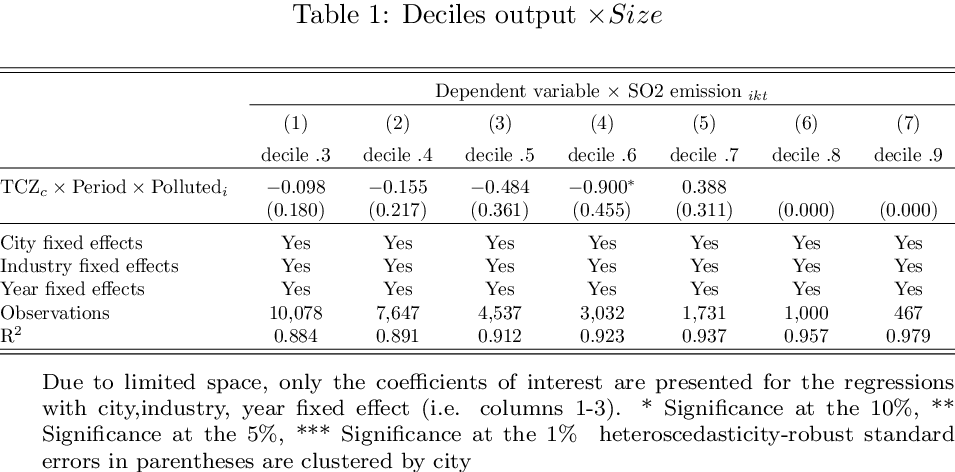

In [30]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 1,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

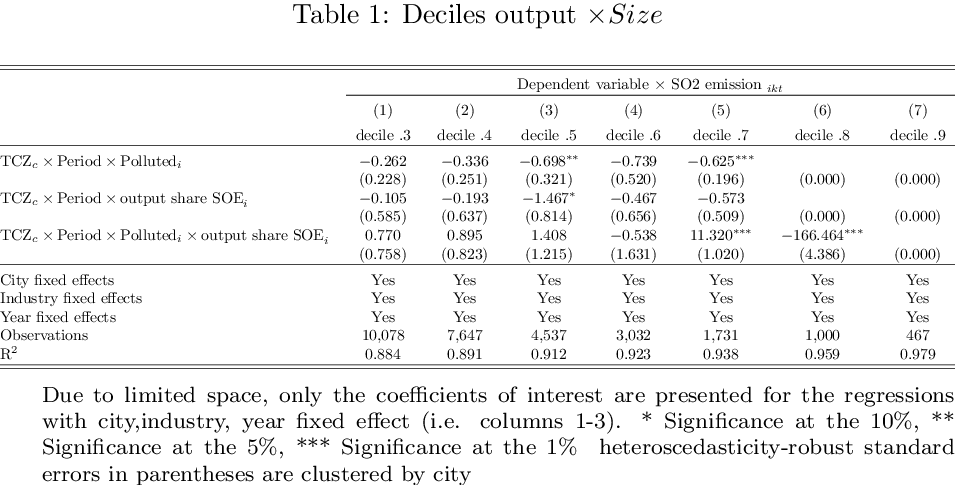

In [31]:
lb.beautify(table_number = 2,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True, 
           resolution = 200)

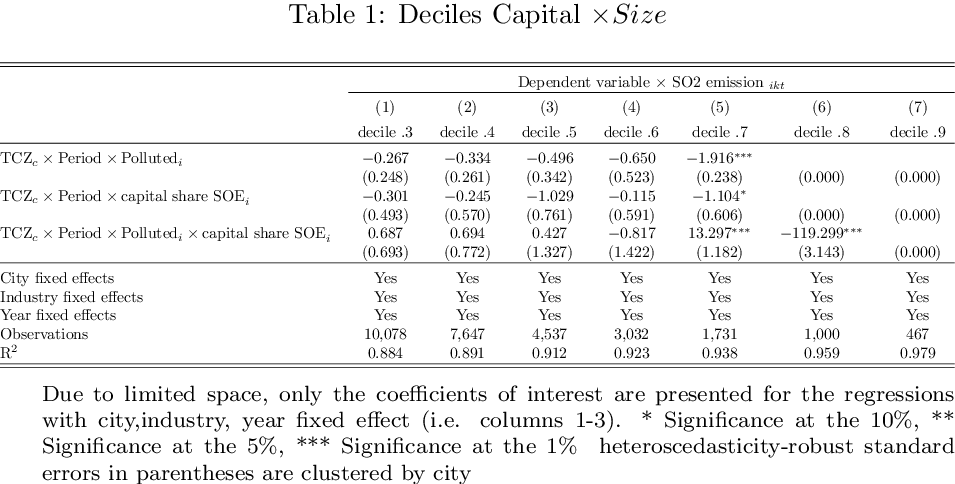

In [32]:
lb.beautify(table_number = 3,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True, 
           resolution = 200)

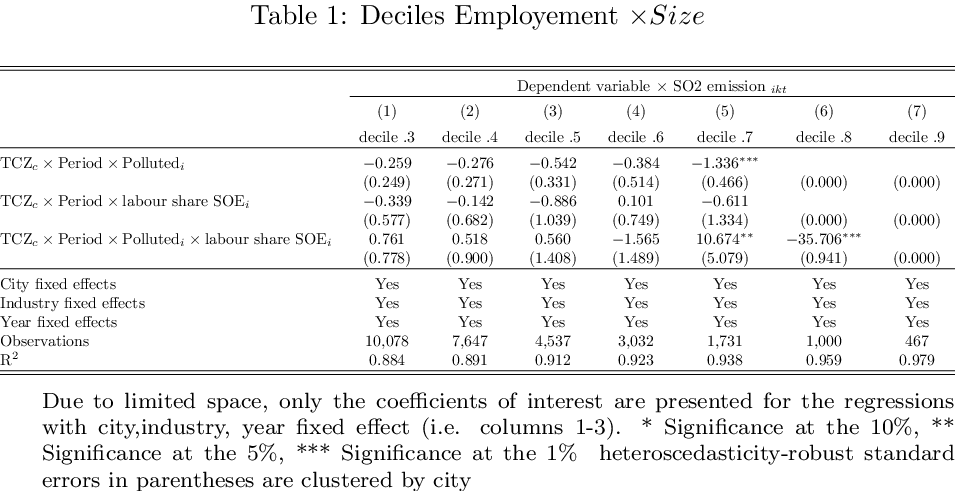

In [33]:
lb.beautify(table_number = 4,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True, 
           resolution = 200)

#### Foreign: Not applicable

Not enough observation, or say differently, no sectors are dominated by Foreign firms solenly

In [35]:
l <- list()
l1 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_FOREIGN %>% filter(rank_share_output_i > i),
             exactDOF=TRUE)
    
    t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_FOREIGN %>% filter(rank_share_output_i > i),
             exactDOF=TRUE)
    
    l[[i - 2]] <- t1
    l1[[i-2]] <- t2
}

#### Capital
l2 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_FOREIGN %>% filter(rank_share_capital_i > i),
             exactDOF=TRUE)

    l2[[i - 2]] <- t1
}

#### Employment
l3 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_FOREIGN %>% filter(rank_share_employement_i > i),
             exactDOF=TRUE)
    
    l3[[i - 2]] <- t1
}

file.remove("table_5.txt")
file.remove("table_5.tex")
file.remove("table_6.txt")
file.remove("table_6.tex")
file.remove("table_7.txt")
file.remove("table_7.tex")
file.remove("table_8.txt")
file.remove("table_8.tex")

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(l,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: Foreign',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_5.txt"
)

table_1 <- go_latex(l1,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: Foreign',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_6.txt"
)

table_1 <- go_latex(l2,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Capital: Foreign',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_7.txt"
)
table_1 <- go_latex(l3,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Employement: Foreign',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_8.txt"
)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

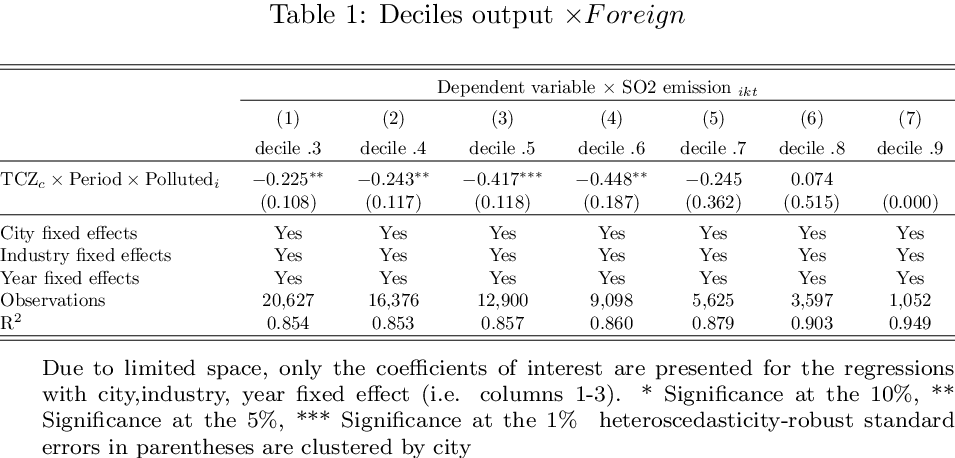

In [36]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 5,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

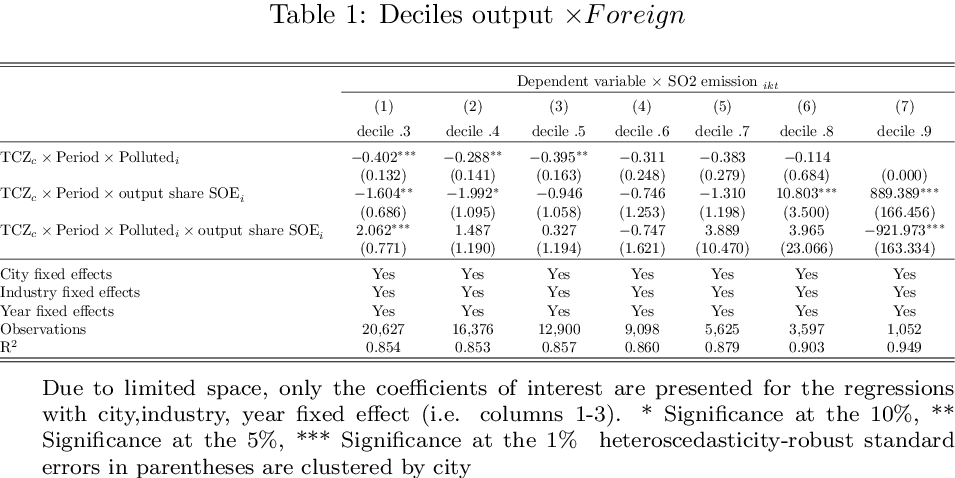

In [37]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 6,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

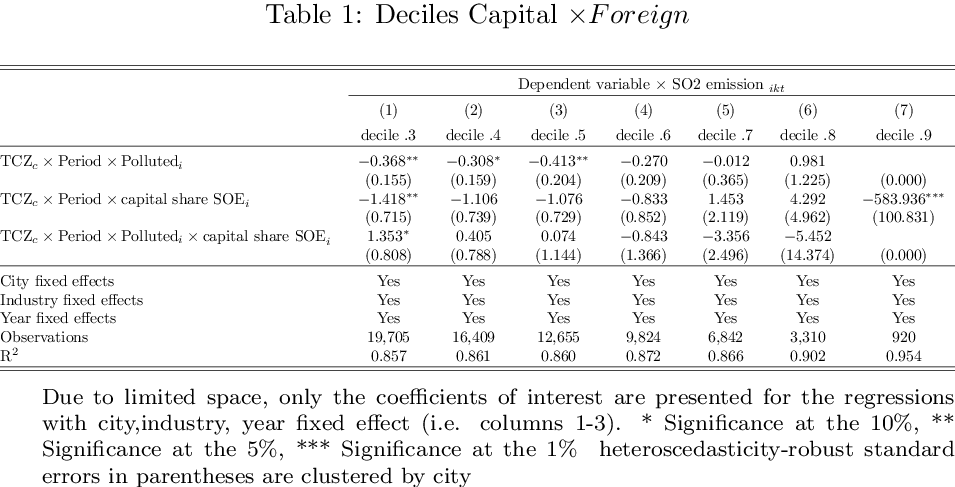

In [38]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 7,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

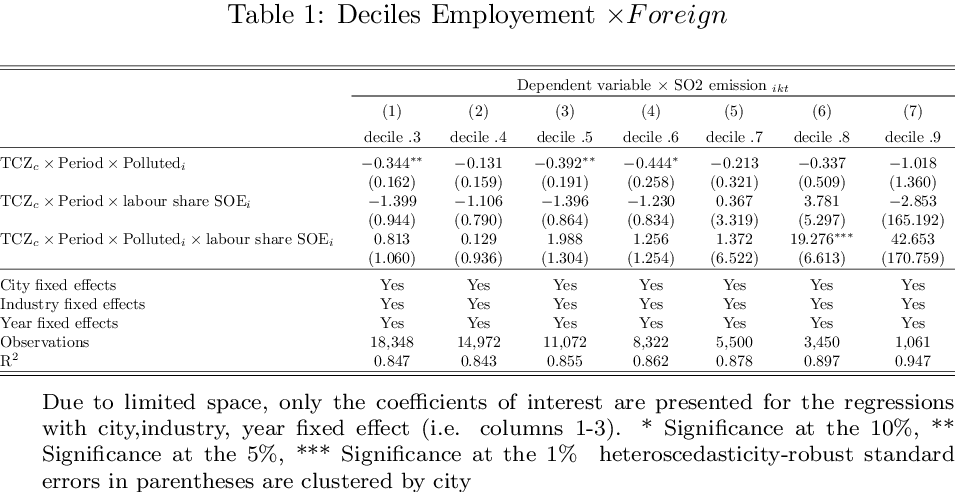

In [39]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 8,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

#### SOE

In [40]:
#### Output
l <- list()
l1 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period * polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(rank_share_output_i > i),
             exactDOF=TRUE)
    
    t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(rank_share_output_i > i),
             exactDOF=TRUE)
    
    l[[i - 2]] <- t1
    l1[[i-2]] <- t2
}

#### Capital
l2 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(rank_share_capital_i > i),
             exactDOF=TRUE)

    l2[[i - 2]] <- t1
}

#### Employment
l3 <- list()
for (i in seq(3, 9)){
    
    t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(rank_share_employement_i > i),
             exactDOF=TRUE)
    
    l3[[i - 2]] <- t1
}

file.remove("table_9.txt")
file.remove("table_9.tex")
file.remove("table_10.txt")
file.remove("table_10.tex")
file.remove("table_11.txt")
file.remove("table_11.tex")
file.remove("table_12.txt")
file.remove("table_12.tex")

fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects","Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(l,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_9.txt"
)

table_1 <- go_latex(l1,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles output: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_10.txt"
)

table_1 <- go_latex(l2,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Capital: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_11.txt"
)
table_1 <- go_latex(l3,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Deciles Employement: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_12.txt"
)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

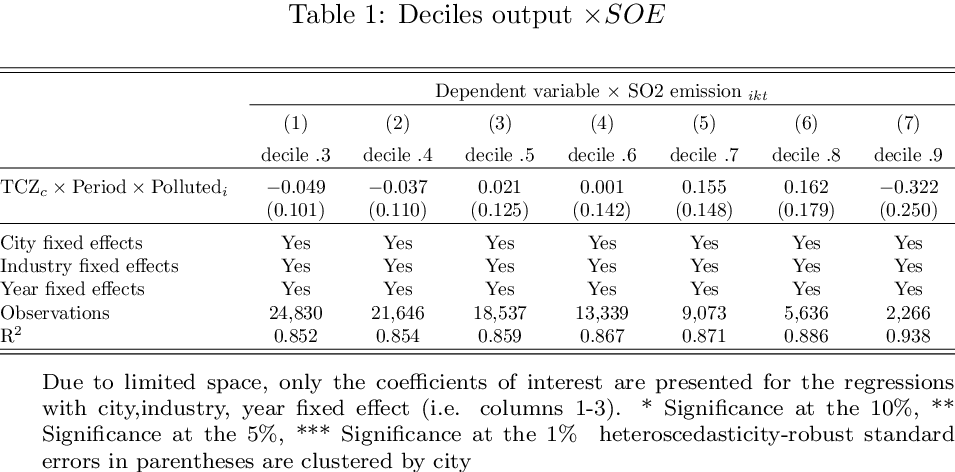

In [41]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 9,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

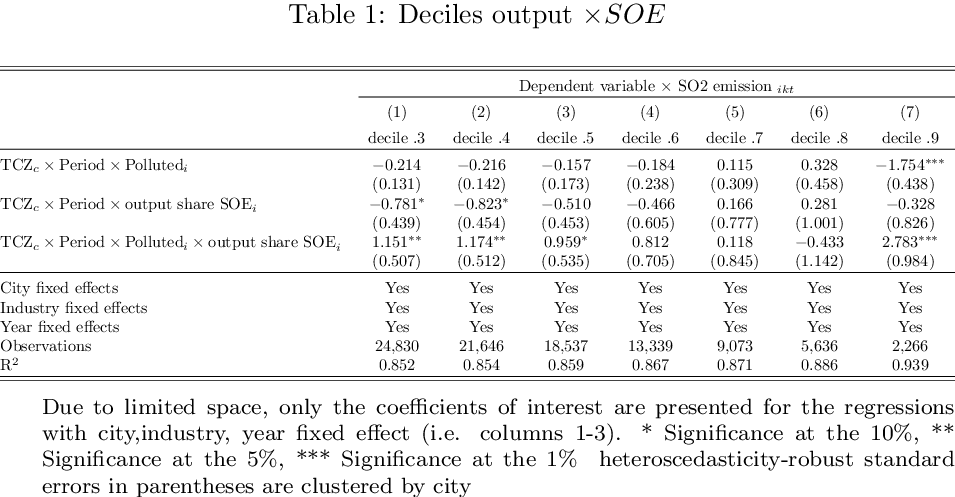

In [42]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 10,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

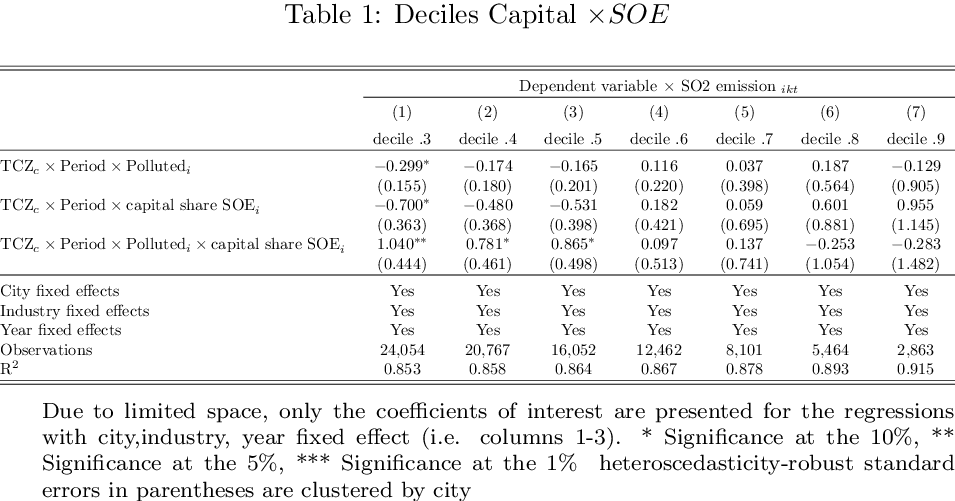

In [43]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 11,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

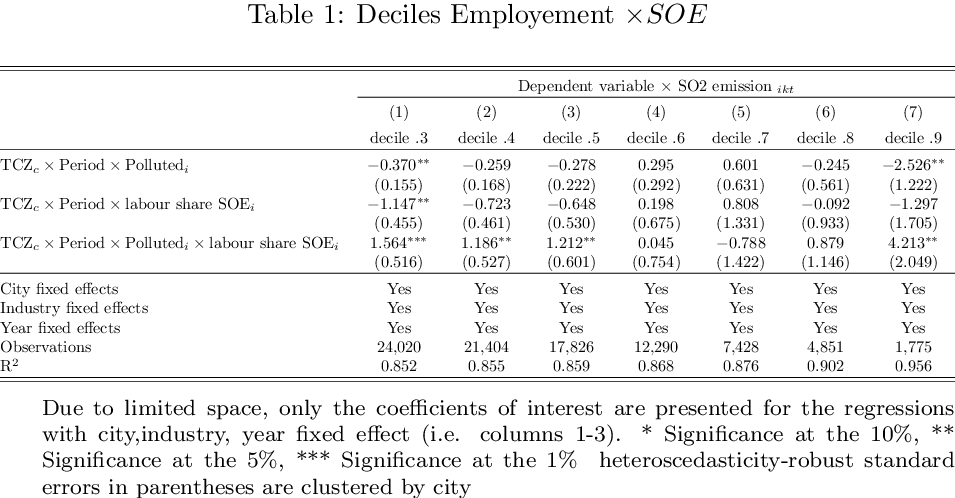

In [44]:
import os
decile=['& decile .3', 'decile .4',
        'decile .5','decile .6', ' decile .7', 
       'decile .8','decile .9']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 12,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
           jupyter_preview = True,
           resolution = 200)

### Absolute

#### SOE

Reminder, in the table below, we include sectors solenly dominated by SOE -> Share output/cap/emp of SOE stricly superior with Private

In [46]:
##### Panel A
## Output
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Above'),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Above'),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Above'),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Above'),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Above'),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Above'),
             exactDOF=TRUE)
la <- list(t1, t2, t3, t4, t5, t6)
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### Panel B
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Below'),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(output =='Below'),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Below'),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(capital =='Below'),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Below'),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_final_SOE %>% filter(employment =='Below'),
             exactDOF=TRUE)
lb <- list(t1, t2, t3, t4, t5, t6)

file.remove("table_13.txt")
file.remove("table_13.tex")
file.remove("table_14.txt")
file.remove("table_14.tex")
fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(la,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel A: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_13.txt"
)
table_1 <- go_latex(lb,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel B: SOE',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_14.txt"
)

[1] TRUE

[1] FALSE

[1] FALSE

[1] FALSE

In [ ]:
import os
decile=['& Output','Output',
        'Capital', 'Capital',
       'Employment','Employment']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 13,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
           resolution = 200)

In [ ]:
lb.beautify(table_number = 14,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
            resolution = 200)

### Coastal

In [ ]:
##### Panel A: Coastal
## Output
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == TRUE),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == TRUE),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == TRUE),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == TRUE),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == TRUE),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == TRUE),
             exactDOF=TRUE)
la <- list(t1, t2, t3, t4, t5, t6)
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### Panel B
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == FALSE),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == FALSE),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == FALSE),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == FALSE),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == FALSE),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(Coastal == FALSE),
             exactDOF=TRUE)
lb <- list(t1, t2, t3, t4, t5, t6)

file.remove("table_15.txt")
file.remove("table_15.tex")
file.remove("table_16.txt")
file.remove("table_16.tex")
fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(la,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel A: Coastal',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_15.txt"
)
table_1 <- go_latex(lb,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel B: Coastal',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_1(.txt"
)

In [ ]:
import os
decile=['& Output','Output',
        'Capital', 'Capital',
       'Employment','Employment']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 15,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
           resolution = 200)

In [ ]:
import os
decile=['& Output','Output',
        'Capital', 'Capital',
       'Employment','Employment']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 16,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
           resolution = 200)

### SPZ

In [ ]:
##### Panel A: Coastal
## Output
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 1),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 1),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 1),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 1),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 1),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data=df_TCZ_list_china %>% filter(SPZ == 1),
             exactDOF=TRUE)
la <- list(t1, t2, t3, t4, t5, t6)
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 
##### Panel B
t1 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 0),
             exactDOF=TRUE)
    
t2 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * out_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 0),
             exactDOF=TRUE)
## Capital
t3 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 0),
             exactDOF=TRUE)
    
t4 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * cap_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 0),
             exactDOF=TRUE)

## Employment
t5 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre 
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 0),
             exactDOF=TRUE)
    
t6 <- felm(formula=log(tso2_cit) ~ TCZ_c * Period *polluted_thre * lab_share_SOE
                  + output_fcit + capital_fcit + labour_fcit
                  |
             FE_t_c + FE_t_i + FE_c_i  | 0 |
             industry, data= df_TCZ_list_china %>% filter(SPZ == 0),
             exactDOF=TRUE)
lb <- list(t1, t2, t3, t4, t5, t6)

file.remove("table_17.txt")
file.remove("table_17.tex")
file.remove("table_18.txt")
file.remove("table_18.tex")
fe1 <- list(
    c("City fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Industry fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
             c("Year fixed effects", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(la,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel A: SPZ',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_17.txt"
)
table_1 <- go_latex(lb,
    dep_var = "Dependent variable: \\text { SO2 emission }_{i k t}",
    title='Panel B: SPZ',
    addFE=fe1,
    save=TRUE,
                    note = FALSE,
    name="table_18.txt"
)

In [ ]:
import os
decile=['& Output','Output',
        'Capital', 'Capital',
       'Employment','Employment']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 17,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
           resolution = 200)

In [ ]:
import os
decile=['& Output','Output',
        'Capital', 'Capital',
       'Employment','Employment']

tb = """\\footnotesize{
Due to limited space, only the coefficients of interest are presented 
for the regressions with city,industry, year fixed effect (i.e. columns 1-3).
\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\% \\
heteroscedasticity-robust standard errors in parentheses are clustered by city 
}
"""
lb.beautify(table_number = 18,
            remove_control= True,
            constraint = False,
            city_industry = False, 
            new_row = decile,
            table_nte =tb,
            jupyter_preview = True, 
           resolution = 200)